# Outline

- Today we will show how to train a ConvNN using PyTorch
- We will also illustrate how the ConvNN makes use of specific assumptions

In [1]:
from res.plot_lib import plot_data, plot_model, set_default

In [2]:
set_default()

In [3]:
import torch
import torch.nn as nn 
import torch.nn.functional as F
import torch.optim as optim 
from torchvision import datasets, transforms
import matplotlib.pyplot as plt 
import numpy

In [4]:
# function to count number of parameters
def get_n_params(model):
    np = 0
    for p in list(model.parameters()):
        np += p.nelement()
    return np

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


## Load the Dataset (MNIST)

We can use some PyTorch DatasLoader utilities for this. This will download, normalize data and arrange it in batches.

In [6]:
input_size = 28*28 # images are 28x28 pixels
output_size = 10 # there are 10 classess

train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,),(0.3081,))
                   ])),
    batch_size=64, shuffle=True
)


test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=1000, shuffle=True)

100%|██████████| 9912422/9912422 [00:00<00:00, 94302719.01it/s]

Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 56263675.72it/s]

Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 37800844.99it/s]


Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 4531524.45it/s]

Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw



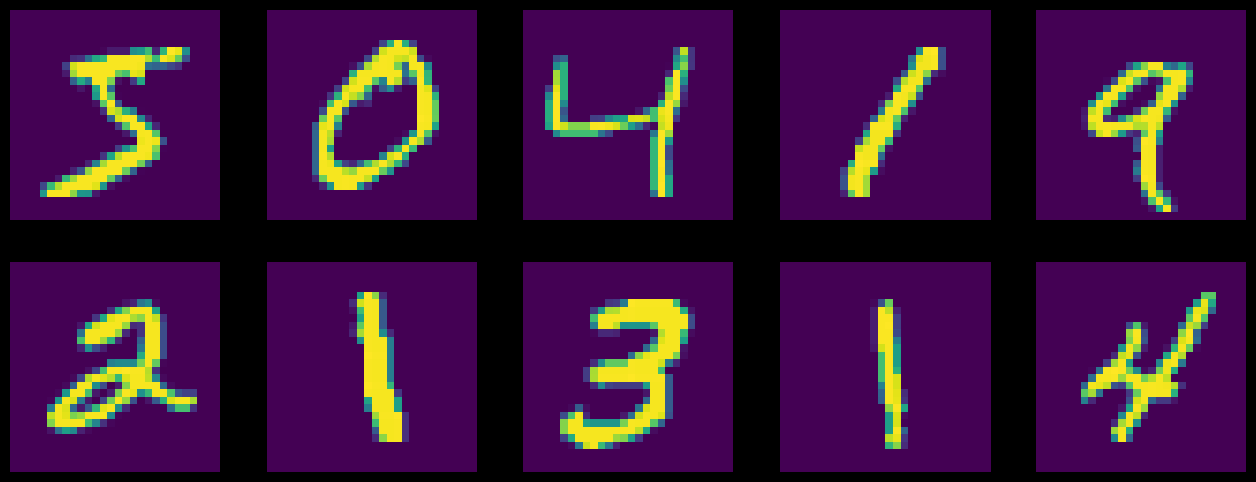

In [7]:
# show some images
plt.figure(figsize=(16, 6))
for i in range(10):
    plt.subplot(2, 5, i+1)
    image, _ = train_loader.dataset.__getitem__(i)
    plt.imshow(image.squeeze().numpy())
    plt.axis('off')

## Create the model classes

In [8]:
class FC2Layer(nn.Module):
    def __init__(self, input_size, n_hidden, output_size):
        super(FC2Layer, self).__init__()
        self.input_size = input_size
        self.network = nn.Sequential(
            nn.Linear(input_size, n_hidden),
            nn.ReLU(),
            nn.Linear(n_hidden, n_hidden),
            nn.ReLU(),
            nn.Linear(n_hidden, output_size),
            nn.LogSoftmax(dim=1)
        )
        
    def forward(self, x):
        x = x.view(-1, self.input_size)
        return self.network(x)
    
class CNN(nn.Module):
    def __init__(self, input_size, n_feature, output_size):
        super(CNN, self).__init__()
        self.n_feature = n_feature
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=n_feature, kernel_size=5)
        self.conv2 = nn.Conv2d(n_feature, n_feature, kernel_size=5)
        self.fc1 = nn.Linear(n_feature*4*4, 50)
        self.fc2 = nn.Linear(50, 10)
    
    def forward(self, x, verbose=False):
        x = self.conv1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)
        x = x.view(-1, self.n_feature*4*4)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.log_softmax(x, dim=1)
        return x
        
        

# Running on a GPU: device string

Switching between CPU and GPU in PyTorch is controlled via a device string, which will seemlessly determine whether GPU is avaliable, falling back to CPU if not.

In [12]:
accuracy_list = []

def train(epoch, model, perm=torch.arange(0, 784).long()):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        # send to device
        data, target = data.to(device), target.to(device)
        
        # permute pixels
        data = data.view(-1, 28*28)
        data = data[:, perm]
        data = data.view(-1, 1, 28, 28)
        
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print(f'Train Epoch: {epoch} [{batch_idx*len(data)}/{loss.item()}] ')

In [9]:
def test(model, perm=torch.arange(0, 784).long()):
    model.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        # send to device
        data, target = data.to(device), target.to(device)
        
        # permute pixels
        data = data.view(-1, 28*28)
        data = data[:, perm]
        data = data.view(-1, 1, 28, 28)
        output = model(data)
        test_loss += F.nll_loss(output, target, reduction='sum').item()
        pred = output.data.max(1, keepdim=True)[1]
        correct += pred.eq(target.data.view_as(pred)).cpu().sum().item()
        
    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)
    accuracy_list.append(accuracy)
    print(f"\nTest set: Avarage loss: {test_loss}, Accuracy: {correct}/{len(test_loader.dataset)} {accuracy}")
    

In [13]:
# Train a small fully-connected network
n_features = 6

model_cnn = CNN(input_size, n_features, output_size)
model_cnn.to(device)
optimizer = optim.SGD(model_cnn.parameters(), lr=0.01, momentum=0.5)
print(f'Number of parameters : {get_n_params(model_cnn)}')

for epoch in range(0, 1):
    train(epoch, model_cnn)
    test(model_cnn)

Number of parameters : 6422
Train Epoch: 0 [0/2.289947748184204] 
Train Epoch: 0 [6400/1.7536342144012451] 
Train Epoch: 0 [12800/0.722186803817749] 
Train Epoch: 0 [19200/0.44381654262542725] 
Train Epoch: 0 [25600/0.28845080733299255] 
Train Epoch: 0 [32000/0.2848683297634125] 
Train Epoch: 0 [38400/0.20708268880844116] 
Train Epoch: 0 [44800/0.11499398946762085] 
Train Epoch: 0 [51200/0.1680600345134735] 
Train Epoch: 0 [57600/0.28364649415016174] 

Test set: Avarage loss: 0.16744197235107422, Accuracy: 9476/10000 94.76


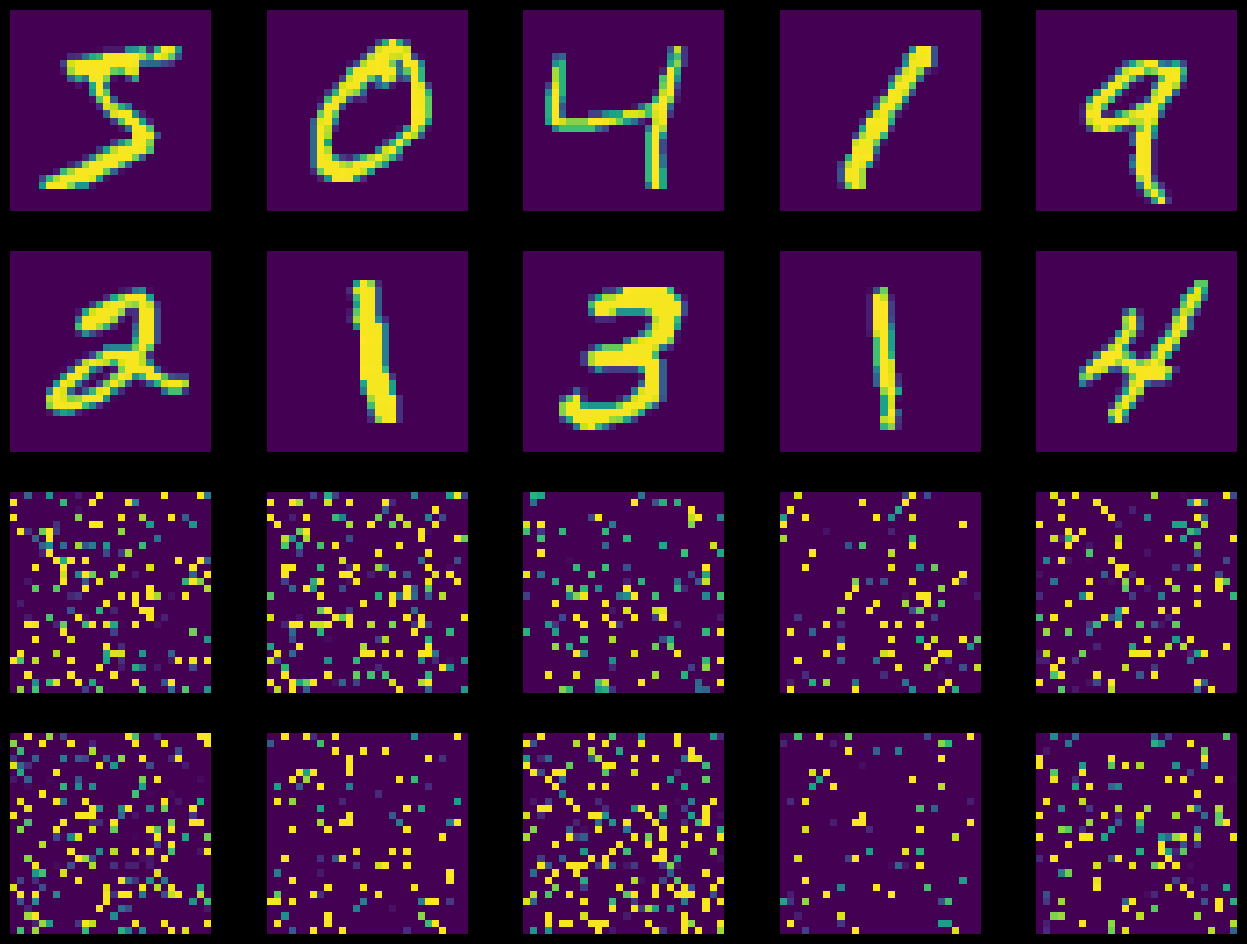

In [14]:
perm = torch.randperm(784)
plt.figure(figsize=(16, 12))
for i in range(10):
    image, _ = train_loader.dataset.__getitem__(i)
    # permute pixels
    image_perm = image.view(-1, 28*28).clone()
    image_perm = image_perm[:, perm]
    image_perm = image_perm.view(-1, 1, 28, 28)
    plt.subplot(4, 5, i + 1)
    plt.imshow(image.squeeze().numpy())
    plt.axis('off')
    plt.subplot(4, 5, i + 11)
    plt.imshow(image_perm.squeeze().numpy())
    plt.axis('off')